# Required libraries

In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Database Connection and Data Loading

In [2]:
# Add project directory path
sys.path.append(os.path.abspath(".."))

# Establish database connection
from database.db_connection import DatabaseConnector

# Error handling for database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit program on connection error

# Load data
try:
    forecast_df = pd.read_sql("SELECT datetime, temperature_2m FROM historical_forecast;", engine)
    weather_df = pd.read_sql("SELECT datetime, temperature_2m, relative_humidity_2m, cloud_cover FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data: {e}")
    sys.exit(1)

# Convert datetime format
try:
    forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
except Exception as e:
    print(f"Error in datetime formatting: {e}")
    sys.exit(1)

# Data preparation

In [3]:
# Merge forecast and weather data for comparison
merged_df = pd.merge(forecast_df, weather_df, how='inner', on=['datetime'], suffixes=('_forecast', '_actual'))

# Calculate temperature differences
merged_df['temperature_difference'] = merged_df['temperature_2m_forecast'] - merged_df['temperature_2m_actual']

# Select relevant features
X = merged_df[['temperature_2m_forecast', 'cloud_cover']]
y = merged_df['temperature_difference']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models

In [4]:
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Train models

In [5]:
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Make predictions

In [6]:
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models

In [7]:
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("=== Linear Regression ===")
print(f"Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"R²: {r2_linear:.2f}")

print("\n=== Random Forest Regressor ===")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

=== Linear Regression ===
Mean Squared Error (MSE): 2.10
R²: 0.03

=== Random Forest Regressor ===
Mean Squared Error (MSE): 2.36
R²: -0.09


# Feature importance from Random Forest

In [8]:
feature_importances = rf_model.feature_importances_
print("\nFeature Importances (Random Forest):")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

# Highlight the importance of 'cloud_cover'
if 'cloud_cover' in X.columns:
    cloud_cover_importance = feature_importances[list(X.columns).index('cloud_cover')]
    print(f"\nThe importance of 'cloud_cover' is {cloud_cover_importance:.4f}, indicating its influence on temperature prediction errors.")


Feature Importances (Random Forest):
temperature_2m_forecast: 0.5667
cloud_cover: 0.4333

The importance of 'cloud_cover' is 0.4333, indicating its influence on temperature prediction errors.


# Visualization of predictions

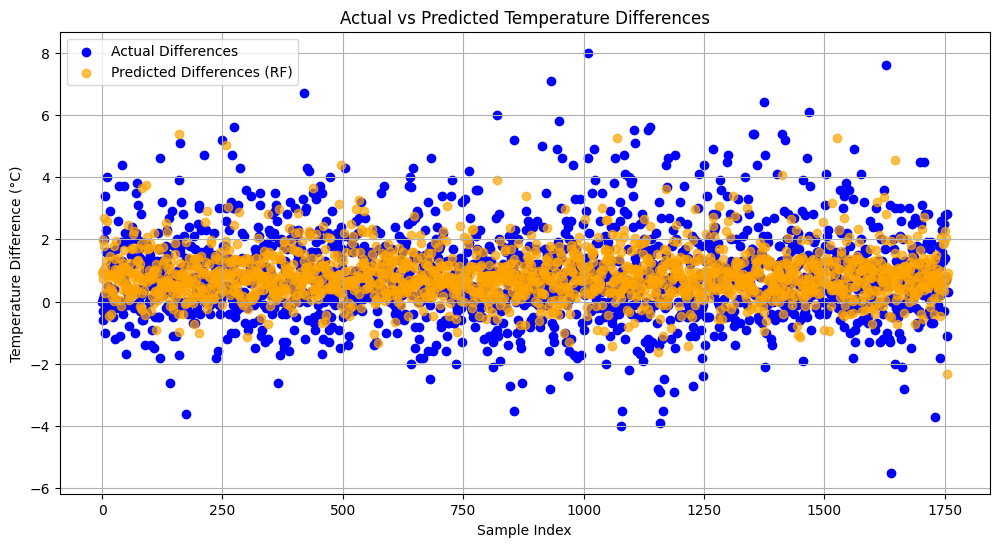

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Differences')
plt.scatter(range(len(y_pred_rf)), y_pred_rf, color='orange', label='Predicted Differences (RF)', alpha=0.7)
plt.title("Actual vs Predicted Temperature Differences")
plt.xlabel("Sample Index")
plt.ylabel("Temperature Difference (\u00b0C)")
plt.legend()
plt.grid()
plt.show()


## Interpretation:

If 'cloud_cover' has a high feature importance score, this suggests that cloud cover significantly influences temperature prediction errors.
A deeper analysis can explore why cloud cover impacts prediction accuracy, potentially by examining specific weather scenarios (e.g., cloudy vs. clear conditions).